# Plastic 2D truss with linear bar elements
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/truss/plasticity_2D.ipynb)

A plastic truss with ten nodes and 20 rods. 

In [1]:
import matplotlib.pyplot as plt
import torch

from torchfem import Truss
from torchfem.materials import IsotropicPlasticity1D

torch.set_default_dtype(torch.float64)

## Material model 

We define a isotropic linear hardening plasticity material model.

In [2]:
# Create material
E = 1000.0
sigma_y = 30.0
k = 500.0


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k


material = IsotropicPlasticity1D(E, sigma_f, sigma_f_prime)

## Model setup

In [3]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

# Create truss
truss = Truss(nodes, elements, material)

# Set boundary conditions
truss.forces[4, 1] = -12.0
truss.constraints[0, 0] = True
truss.constraints[0, 1] = True
truss.constraints[5, 0] = True

## Solve 
In contrast to the linear materials, we define increments ramping up the load.

In [4]:
# Solve
increments = torch.cat((torch.linspace(0.0, 1.0, 21), torch.linspace(1.0, 0.01, 21)))
u, f, σ, F, α = truss.solve(increments=increments, return_intermediate=True)

## Postprocessing 

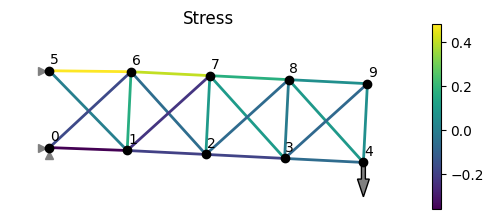

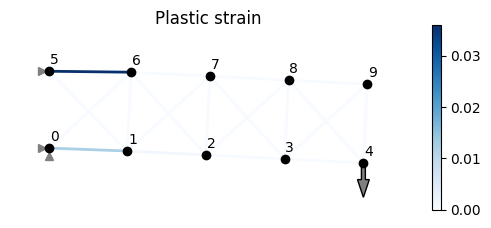

In [5]:
# Plot the deformed truss with stresses
truss.plot(u=u[-1], element_property=σ[-1], title="Stress", cmap="viridis")

# Plot the deformed truss with plastic strains
truss.plot(u=u[-1], element_property=α[-1], title="Plastic strain", cmap="Blues")

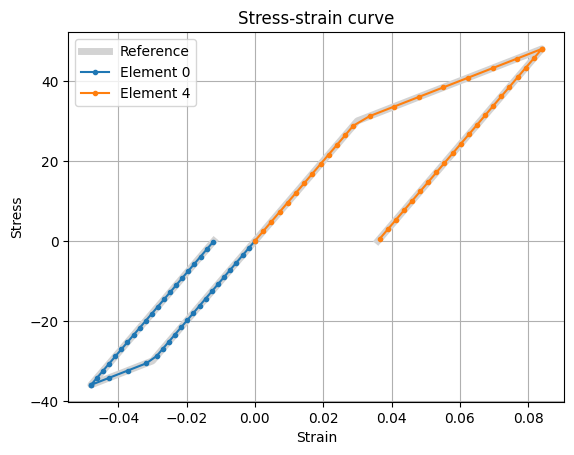

In [10]:
# Compute analytical reference solution for isotropic linear hardening
ε = F - 1.0
ε_min = min(ε[:, :].min(), -sigma_y / E)
σ_min = k * E / (k + E) * (ε_min - sigma_y / k)
ε_max = max(ε[:, :].max(), sigma_y / E)
σ_max = k * E / (k + E) * (ε_max + sigma_y / k)
ref_strain = [
    ε_min - σ_min / E,
    ε_min,
    -sigma_y / E,
    0.0,
    sigma_y / E,
    ε_max,
    ε_max - σ_max / E,
]
ref_stress = [0.0, σ_min, -sigma_y, 0.0, sigma_y, σ_max, 0.0]


# Compare with reference solution
plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.plot(ε[:, 0], σ[:, 0], ".-", label="Element 0")
plt.plot(ε[:, 4], σ[:, 4], ".-", label="Element 4")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.title("Stress-strain curve")
plt.grid()
plt.legend()
plt.show()